# Neural networks and backpropagation

In this notebook we will exercise the feedforward, fully-connected neural network, aka multilayer perceptron (MLP). With a single hidden layer it looks like this:

![](figures/Colored_neural_network.svg)

Every neuron takes a list of inputs $x_i$, applies a weighted sum and feeds the result into an activation function $f$ such that the output $a_i$ is given by

$$a_i = f\left(\sum_j w_{ij} x_j\right) \quad \text{or} \quad \vec a = f(W\vec x)$$

Note how the argument of the activation function is essentially a **matrix multiplication** of the weight matrix with the input vector!

For an arbitrary number of layers the output vector of layer $l$ $\vec a^(l)$ is then calculated from the output vector $\vec a^{(l-1)}$ of the previous layer:

$$\vec a^{(l)} = f(W^{(l)}\vec a^{(l-1)})$$

Popular choices for the activation function include ([source][2]):

![1]

We will implement a simple 1-hidden-layer neural network first using available libraries and then manually.

[1]: figures/activation_functions.png "overview of commonly used activation functions"
[2]: https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning

We use again our toy example for the 2-moons 2D dataset:

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, y = make_moons(noise=0.25, n_samples=100, random_state=0)

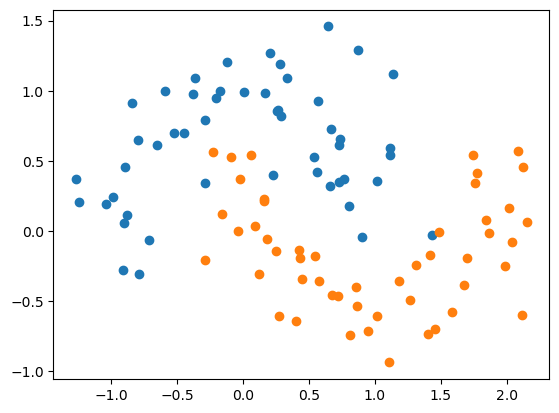

In [3]:
plt.scatter(*X[y==0].T)
plt.scatter(*X[y==1].T)

# With sklearn

A simple MLP classifier is available in scikit-learn:

In [4]:
from sklearn.neural_network import MLPClassifier

In [5]:
model = MLPClassifier(max_iter = 1000).fit(X, y)

/software/opt/el_9/x86_64/python/3.11-2023.09/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


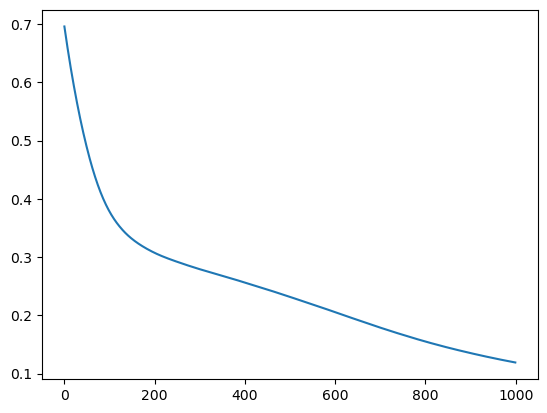

In [6]:
plt.plot(model.loss_curve_)

In [7]:
def visualize_classifier(predict, xmin, xmax, ymin, ymax, **kwargs):
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, 100),
        np.linspace(ymin, ymax, 100),
    )
    X = np.stack([xx, yy], axis=-1).reshape(-1, 2)
    zz = predict(X).reshape(xx.shape)
    plt.contourf(xx, yy, zz, levels=100, **kwargs)

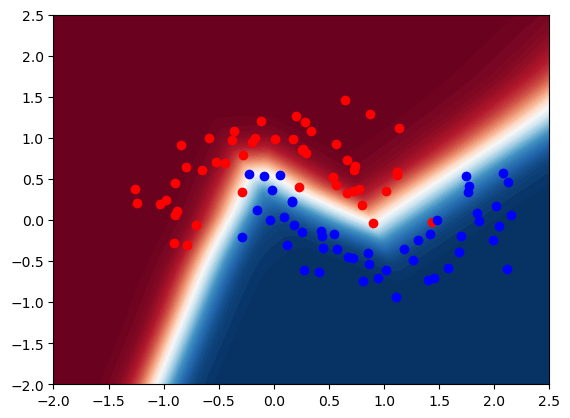

In [8]:
visualize_classifier(lambda x: model.predict_proba(x)[:, 1], -2, 2.5, -2, 2.5, cmap="RdBu")
plt.scatter(*X[y==0].T, color="red")
plt.scatter(*X[y==1].T, color="blue")

Let's tune the parameters a bit to make a relatively simple model that we can then reproduce more and more manually:

In [9]:
model = MLPClassifier(
    hidden_layer_sizes=(32,), solver="sgd", batch_size=len(X), learning_rate_init=0.2, max_iter=1000
).fit(X, y)

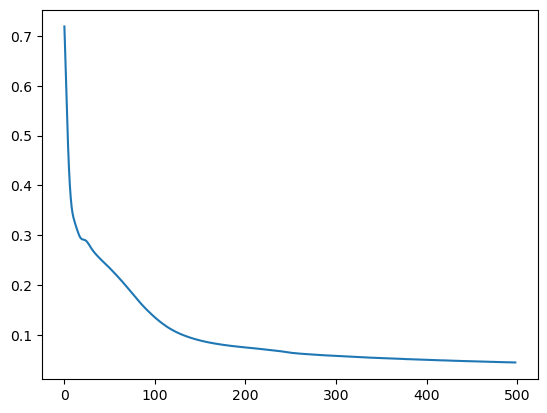

In [10]:
plt.plot(model.loss_curve_)

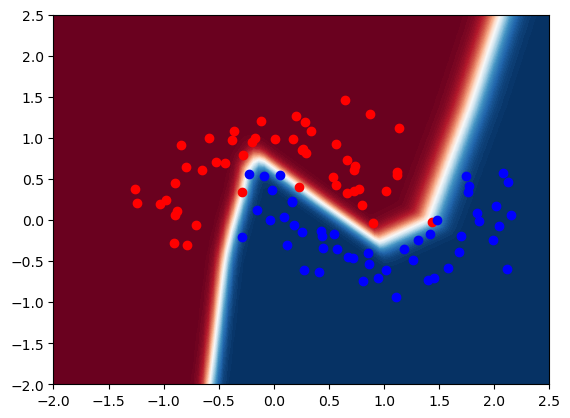

In [11]:
visualize_classifier(lambda x: model.predict_proba(x)[:, 1], -2, 2.5, -2, 2.5, cmap="RdBu")
plt.scatter(*X[y==0].T, color="red")
plt.scatter(*X[y==1].T, color="blue")

# With pytorch

[PyTorch](https://pytorch.org) is one of the most popular machine learning libraries to date (2024). It is mainly developed by Meta AI. Have a look at the [tutorials](https://pytorch.org/tutorials) to learn more.

Other popular choices are [TensorFlow](https://www.tensorflow.org)/[Keras](https://keras.io) and [Jax](https://jax.readthedocs.io)

The main object in torch are so called *tensors* which have a very similar API to numpy arrays. PyTorch builds computation graphs dynamically which allows for a lot of flexibility and easy debugging.

In [12]:
import torch
from torch import nn

To convert a numpy array to a torch tensor, we can just call the `torch.tensor` constructor on it.

For some operations PyTorch is rather strict not to mix data types of different precision. Since most NN parameters are initialized as 32 bit floating point numbers we will also convert our data to this type:

In [13]:
X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

We create our 1-hidden-layer MLP using the `nn.Sequential` constructor:

In [14]:
neurons = 32
model = nn.Sequential(nn.Linear(2, neurons), nn.ReLU(), nn.Linear(neurons, 1), nn.Sigmoid())
model

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=1, bias=True)
  (3): Sigmoid()
)

The `torch.optim` package contains implementations of various optimization algorithms. Here we will just use the plain stochastic gradient descent algorithm:

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)

We told the optimizer about the parameters of the model (which are also just torch tensors) and when we later call `.step()` the optimizer will apply it's update rule using the gradients that have been attached to the parameters.

<div class="alert alert-block alert-success">
    <h2>Exercise 1</h2><br> How many parameters has this model?
</div>

In [16]:
(2*32+32) + (32+1)

129

In [17]:
sum(par.numel() for par in model.parameters())

129

Let's fit the model:

In [18]:
model(X).squeeze(1).shape

torch.Size([100])

In [19]:
history = []
for i in range(1000):
    optimizer.zero_grad()
    y_pred = model(X).squeeze(1)
    loss = nn.functional.binary_cross_entropy(y_pred, y)
    loss.backward()
    history.append(loss.item())
    optimizer.step()

* `optimizer.zero_grad()` resets all gradients to 0. By default torch accumulates gradients if a future backpropagation step is executed. **Don't forget this**
* the forward pass is calculated by `model(X)` - the `.squeeze(1)` changes the shape of the output from (N, 1) to (N,)
* `loss` is our objective we want to minimize, in this case the binary cross entropy (or negative log likelihood)
* `loss.backward()` will run the backward pass and attach the gradient of the loss w.r.t `.grad` attribute of all parameters that have `requires_grad=True` set
* `optimizer.step()` will perform the actual gradient update

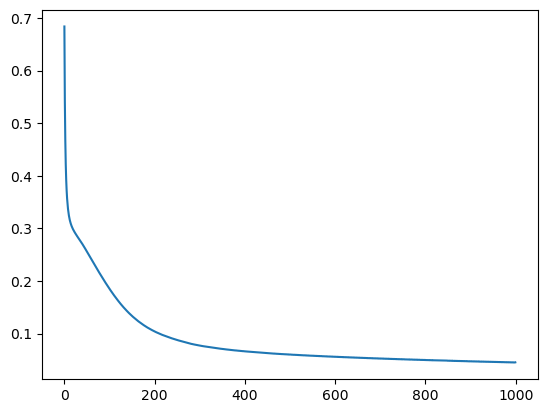

In [20]:
plt.plot(history)

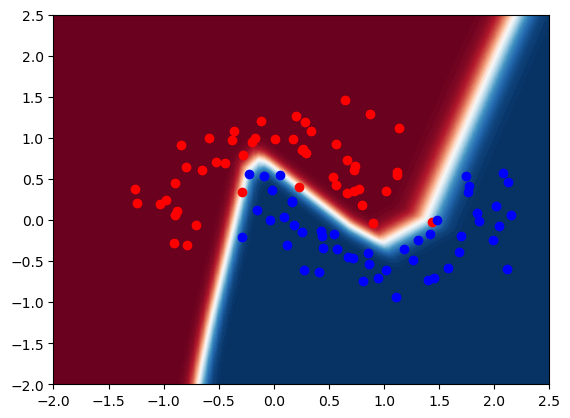

In [21]:
with torch.no_grad():
    visualize_classifier(
        lambda x: model(torch.tensor(x, dtype=torch.float32)).squeeze().numpy(),
        -2, 2.5, -2, 2.5,
        cmap="RdBu"
    )
plt.scatter(*X[y==0].T, color="red")
plt.scatter(*X[y==1].T, color="blue")

# With torch (manual optimizer)

Next, let's leave out the optimizer and perform the gradient update manually, still using pytorch to get the gradient.

To get the gradient of a loss w.r.t. some parameters we have to set `requires_grad=True` for the corresponding tensors:

In [22]:
x = torch.linspace(0, 2*np.pi, 100, requires_grad=True)
x

tensor([0.0000, 0.0635, 0.1269, 0.1904, 0.2539, 0.3173, 0.3808, 0.4443, 0.5077,
        0.5712, 0.6347, 0.6981, 0.7616, 0.8251, 0.8885, 0.9520, 1.0155, 1.0789,
        1.1424, 1.2059, 1.2693, 1.3328, 1.3963, 1.4597, 1.5232, 1.5867, 1.6501,
        1.7136, 1.7771, 1.8405, 1.9040, 1.9675, 2.0309, 2.0944, 2.1579, 2.2213,
        2.2848, 2.3483, 2.4117, 2.4752, 2.5387, 2.6021, 2.6656, 2.7291, 2.7925,
        2.8560, 2.9195, 2.9829, 3.0464, 3.1099, 3.1733, 3.2368, 3.3003, 3.3637,
        3.4272, 3.4907, 3.5541, 3.6176, 3.6811, 3.7445, 3.8080, 3.8715, 3.9349,
        3.9984, 4.0619, 4.1253, 4.1888, 4.2523, 4.3157, 4.3792, 4.4427, 4.5061,
        4.5696, 4.6331, 4.6965, 4.7600, 4.8235, 4.8869, 4.9504, 5.0139, 5.0773,
        5.1408, 5.2043, 5.2677, 5.3312, 5.3947, 5.4581, 5.5216, 5.5851, 5.6485,
        5.7120, 5.7755, 5.8389, 5.9024, 5.9659, 6.0293, 6.0928, 6.1563, 6.2197,
        6.2832], requires_grad=True)

In [23]:
f = torch.sin(x)

Now, all tensors that are created as operations of this will have a `grad_fn` attribute:

In [24]:
f.grad_fn

To convert such tensors (implicitly or explicitly) to numpy arrays we need to "detach" them from the computation graph:

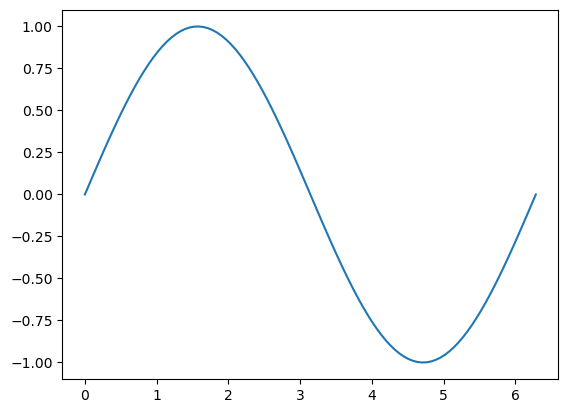

In [25]:
plt.plot(x.detach(), f.detach())

## The VJP
What does `grad_fn` do? It will calculate the so called *vector-Jacobian-product* (VJP)

What is that? To calculate the gradient of a loss function we use the chain rule, in the single variable case

$$\frac{\partial f(g(x))}{\partial x} = \frac{\partial f}{\partial g}\frac{\partial g}{\partial x}$$

and in the [multivariable case](https://en.wikipedia.org/wiki/Chain_rule#General_rule:_Vector-valued_functions_with_multiple_inputs) ($x\in \mathbb{R}^n, g: \mathbb{R}^n\rightarrow\mathbb{R}^m, f: \mathbb{R}^m\rightarrow\mathbb{R}^k$)

$$\mathbf{J}_f(g(x)) = \mathbf{J}_f(g)\mathbf{J}_g(x),\quad \text{in components} \quad \frac{\partial f_i}{\partial x_j}=\frac{\partial f_i}{\partial g_k}\frac{\partial g_k}{\partial x_j}$$

For **the gradient of a scalar** (loss):

$$\frac{\partial f}{\partial x_j}=\underbrace{\frac{\partial f}{\partial g_k}}_{\mathrm{vector}}\underbrace{\frac{\partial g_k}{\partial x_j}}_{\mathrm{Jacobian}}$$

So we need to matrix multiply the (**incoming**) gradient (row) **vector** with the **Jacobian** in each step, the vector-Jacobian-product **VJP**.

The cool thing: usually we **don't need to compute the full Jacobian to get the VJP!**

E.g. here, our tensor `f` applies a sin function componentwise to an input `x`. It's pretty clear we don't need to compute the Jacobian (it's a diagonal matrix).

So, the VJP-way of calculating the derivative componentwise would be to take an incoming gradient vector that is all ones:

In [26]:
v = torch.ones_like(f)
v

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

and calculate the VJP by just multiplying this with the componentwise derivative, here the cosine:

In [27]:
vjp = v * torch.cos(x)
vjp

tensor([ 1.0000,  0.9980,  0.9920,  0.9819,  0.9679,  0.9501,  0.9284,  0.9029,
         0.8738,  0.8413,  0.8053,  0.7660,  0.7237,  0.6785,  0.6306,  0.5801,
         0.5272,  0.4723,  0.4154,  0.3569,  0.2969,  0.2358,  0.1736,  0.1108,
         0.0476, -0.0159, -0.0793, -0.1423, -0.2048, -0.2665, -0.3271, -0.3863,
        -0.4441, -0.5000, -0.5539, -0.6056, -0.6549, -0.7015, -0.7453, -0.7861,
        -0.8237, -0.8580, -0.8888, -0.9161, -0.9397, -0.9595, -0.9754, -0.9874,
        -0.9955, -0.9995, -0.9995, -0.9955, -0.9874, -0.9754, -0.9595, -0.9397,
        -0.9161, -0.8888, -0.8580, -0.8237, -0.7861, -0.7453, -0.7015, -0.6549,
        -0.6056, -0.5539, -0.5000, -0.4441, -0.3863, -0.3271, -0.2665, -0.2048,
        -0.1423, -0.0792, -0.0159,  0.0476,  0.1108,  0.1736,  0.2358,  0.2969,
         0.3569,  0.4154,  0.4723,  0.5272,  0.5801,  0.6306,  0.6785,  0.7237,
         0.7660,  0.8053,  0.8413,  0.8738,  0.9029,  0.9284,  0.9501,  0.9679,
         0.9819,  0.9920,  0.9980,  1.00

This is also what `grad_fn` will do

In [28]:
f.grad_fn(v)

tensor([ 1.0000,  0.9980,  0.9920,  0.9819,  0.9679,  0.9501,  0.9284,  0.9029,
         0.8738,  0.8413,  0.8053,  0.7660,  0.7237,  0.6785,  0.6306,  0.5801,
         0.5272,  0.4723,  0.4154,  0.3569,  0.2969,  0.2358,  0.1736,  0.1108,
         0.0476, -0.0159, -0.0793, -0.1423, -0.2048, -0.2665, -0.3271, -0.3863,
        -0.4441, -0.5000, -0.5539, -0.6056, -0.6549, -0.7015, -0.7453, -0.7861,
        -0.8237, -0.8580, -0.8888, -0.9161, -0.9397, -0.9595, -0.9754, -0.9874,
        -0.9955, -0.9995, -0.9995, -0.9955, -0.9874, -0.9754, -0.9595, -0.9397,
        -0.9161, -0.8888, -0.8580, -0.8237, -0.7861, -0.7453, -0.7015, -0.6549,
        -0.6056, -0.5539, -0.5000, -0.4441, -0.3863, -0.3271, -0.2665, -0.2048,
        -0.1423, -0.0792, -0.0159,  0.0476,  0.1108,  0.1736,  0.2358,  0.2969,
         0.3569,  0.4154,  0.4723,  0.5272,  0.5801,  0.6306,  0.6785,  0.7237,
         0.7660,  0.8053,  0.8413,  0.8738,  0.9029,  0.9284,  0.9501,  0.9679,
         0.9819,  0.9920,  0.9980,  1.00

`.backward` will then go through the whole chain of computations backwards and calculate the VJP in each step.

Here we only have one step. Since our tensor is not a scalar we need to feed in the incoming gradient as well:

In [29]:
f.backward(v)

This doesn't return anything, but rather attach the resulting gradient to all tensors with `requires_grad=True` (in torch called "leaf" tensors)

In [30]:
x.grad

tensor([ 1.0000,  0.9980,  0.9920,  0.9819,  0.9679,  0.9501,  0.9284,  0.9029,
         0.8738,  0.8413,  0.8053,  0.7660,  0.7237,  0.6785,  0.6306,  0.5801,
         0.5272,  0.4723,  0.4154,  0.3569,  0.2969,  0.2358,  0.1736,  0.1108,
         0.0476, -0.0159, -0.0793, -0.1423, -0.2048, -0.2665, -0.3271, -0.3863,
        -0.4441, -0.5000, -0.5539, -0.6056, -0.6549, -0.7015, -0.7453, -0.7861,
        -0.8237, -0.8580, -0.8888, -0.9161, -0.9397, -0.9595, -0.9754, -0.9874,
        -0.9955, -0.9995, -0.9995, -0.9955, -0.9874, -0.9754, -0.9595, -0.9397,
        -0.9161, -0.8888, -0.8580, -0.8237, -0.7861, -0.7453, -0.7015, -0.6549,
        -0.6056, -0.5539, -0.5000, -0.4441, -0.3863, -0.3271, -0.2665, -0.2048,
        -0.1423, -0.0792, -0.0159,  0.0476,  0.1108,  0.1736,  0.2358,  0.2969,
         0.3569,  0.4154,  0.4723,  0.5272,  0.5801,  0.6306,  0.6785,  0.7237,
         0.7660,  0.8053,  0.8413,  0.8738,  0.9029,  0.9284,  0.9501,  0.9679,
         0.9819,  0.9920,  0.9980,  1.00

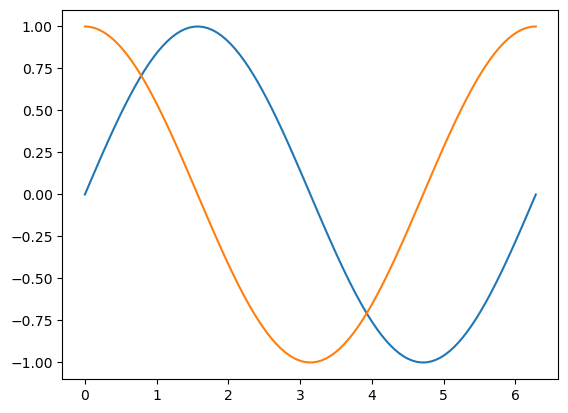

In [31]:
plt.plot(x.detach(), f.detach())
plt.plot(x.detach(), x.grad)

With that, we will now fit our neural network again, implementing the gradient step manually:

In [67]:
model = nn.Sequential(nn.Linear(2, neurons), nn.ReLU(), nn.Linear(neurons, 1), nn.Sigmoid())

To update a tensor in-place, adding a value we can use the `add_` method. Our gradient update will just add the negative gradient, scaled by a learning rate `lr` to each of parameters:

In [68]:
def step(lr=1):
    with torch.no_grad():
        for par in model.parameters():
            par.add_(-lr * par.grad)

The `torch.no_grad()` context manager ensures that all operations in this block won't be attached to the computation graph.

The training loop becomes:

In [69]:
history = []
for i in range(1000):
    model.zero_grad()
    y_pred = model(X).squeeze(1)
    loss = nn.functional.binary_cross_entropy(y_pred, y)
    loss.backward()
    step()
    history.append(loss.detach().item())

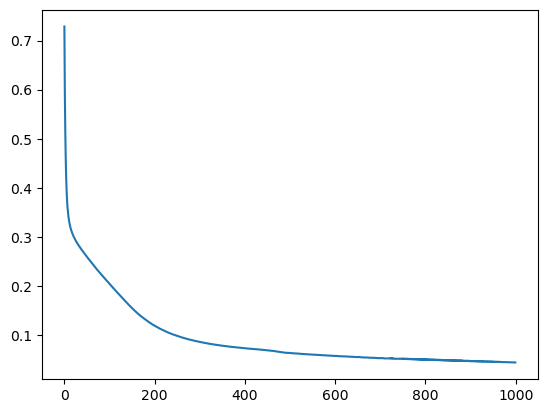

In [70]:
plt.plot(history)

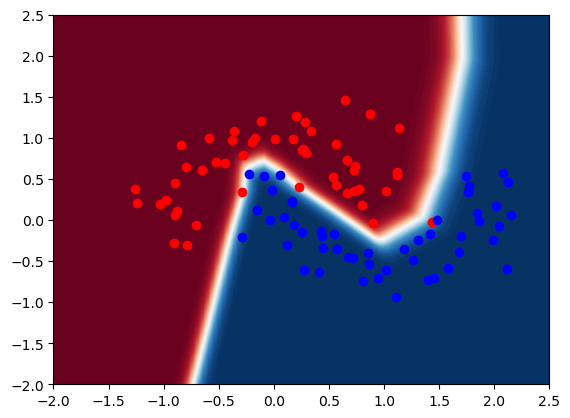

In [71]:
with torch.no_grad():
    visualize_classifier(lambda x: model(torch.tensor(x, dtype=torch.float32)).squeeze(1), -2, 2.5, -2, 2.5, cmap="RdBu")
plt.scatter(*X[y==0].T, color="red")
plt.scatter(*X[y==1].T, color="blue")

# With torch (manual backpropagation)

Now we want to also calculate the backward pass completely manually, meaning taking the VJP in each step ourself.

This part is inspired by [part 4](https://www.youtube.com/watch?v=q8SA3rM6ckI) of [Andrej Karpathy's *Neural Networks: Zero to Hero* tutorials](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

First, when we define the parameters of the network we will also need to decide for starting values.

Typically they are initialized to small random values around 0. While there are [schemes that optimize this](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_), here we will just take a standard normal distribution, scaled by 0.1 for all the parameters:

In [37]:
w1 = (torch.randn(2, neurons) * 0.1).requires_grad_()
w1

tensor([[-0.1097,  0.1113, -0.0003, -0.1051, -0.0755,  0.0491,  0.0098, -0.0086,
         -0.0503,  0.0198, -0.0655,  0.1201, -0.1389,  0.0420, -0.0870,  0.0043,
          0.0567, -0.0170,  0.0109,  0.0156,  0.1003,  0.1555, -0.0109, -0.0528,
         -0.0956,  0.0065,  0.0107,  0.1028, -0.0602,  0.0302, -0.0335, -0.0839],
        [-0.0436, -0.0514, -0.0035, -0.0428, -0.0376, -0.0184, -0.1018,  0.0737,
         -0.0227,  0.1141,  0.1705,  0.0711, -0.0151,  0.0726, -0.0019,  0.0680,
         -0.1286,  0.0855,  0.1457,  0.0079, -0.0739, -0.0356,  0.1740, -0.1740,
          0.1304,  0.1039,  0.1076, -0.1585,  0.0628, -0.1505,  0.0072,  0.0914]],
       requires_grad=True)

Let's start with a very simple neural network with one hidden layer, no bias and use the mean squared error loss function.

The first intermediate output is the matrix multiplication of the input vectors with the weight matrix of the hidden layer:

In [38]:
z1 = X @ w1; z1.retain_grad()
z1.shape

torch.Size([100, 32])

This was now a matrix-matrix multiplication since we did this for our whole input data at once! When training neural networks we will almost always work with batches of data, so this is very common.

To crosscheck our manual gradient calculations later we will set `retain_grad` for all intermediate outputs, such that torch will also attach gradients to these in the backward pass.

Next, we apply the relu activation function:

In [39]:
a1 = torch.relu(z1); a1.retain_grad()

In [40]:
z1[0], a1[0]

(tensor([-0.0442, -0.0497, -0.0035, -0.0434, -0.0380, -0.0177, -0.1005,  0.0728,
         -0.0229,  0.1130,  0.1678,  0.0715, -0.0163,  0.0722, -0.0028,  0.0673,
         -0.1265,  0.0843,  0.1442,  0.0080, -0.0720, -0.0336,  0.1718, -0.1726,
          0.1279,  0.1028,  0.1065, -0.1556,  0.0615, -0.1484,  0.0068,  0.0894],
        grad_fn=<SelectBackward0>),
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0728, 0.0000,
         0.1130, 0.1678, 0.0715, 0.0000, 0.0722, 0.0000, 0.0673, 0.0000, 0.0843,
         0.1442, 0.0080, 0.0000, 0.0000, 0.1718, 0.0000, 0.1279, 0.1028, 0.1065,
         0.0000, 0.0615, 0.0000, 0.0068, 0.0894], grad_fn=<SelectBackward0>))

Then we continue to the second (final) layer:

In [41]:
w2 = (torch.randn(neurons, 1) * 0.1).requires_grad_()

In [42]:
z2 = a1 @ w2; z2.retain_grad()
z2.shape

torch.Size([100, 1])

Since this is the final output with one value per data point we will squeeze the last dimension:

In [43]:
z2 = z2.squeeze(1); z2.retain_grad()
z2.shape

torch.Size([100])

We don't apply an activation function, but instead use the linear output to calculate the mean squared error:

In [44]:
loss = torch.mean((y - z2) ** 2)
loss

tensor(0.4908, grad_fn=<MeanBackward0>)

For crosscheck we run the backward pass with torch:

In [45]:
loss.backward()

Now we manually go backwards. We will create variables with `d` in front of them where e.g. `dz2` means gradient of loss wrt all components of `z2`

The gradient of the loss $L = \frac{1}{N} \sum_i (y_i - \hat{y}_i)^2$ is given by $\frac{\partial L}{\partial \hat{y}_i} = -\frac{2}{N}(y_i - \hat{y}_i)$

In [46]:
dz2 = - 2 / len(z2) * (y - z2)

crosscheck with what torch got:

In [47]:
(z2.grad == dz2).all()

tensor(True)

Now we need the VJP for a matrix multiplication

<div class="alert alert-block alert-success">
    <h2>Exercise 2</h2>
    What is the VJP for a matrix multiplication?<br>
    <b>Hint:</b> It's also going to be a matrix multiplication. You can try to guess this from the shapes of the involved tensors.
    It's also instructive to derive it once on a sheet of paper.
</div>

The matrix multiplication was `z2 = a1 @ w2`

Since we squeezed the last dimension of `z2` we will have to `unsqueeze` it again for the following operation:

In [48]:
dz2.unsqueeze(1).shape

torch.Size([100, 1])

So we have the following tensor shapes

In [49]:
dz2.unsqueeze(1).shape, a1.shape, w2.shape

(torch.Size([100, 1]), torch.Size([100, 32]), torch.Size([32, 1]))

From this we need to get `da1` and `dw2`, the gradients w.r.t `a1` and `w2` via a VJP with the `dz2` gradient vector

In [50]:
dw2 = torch.transpose(a1, 0, 1) @ dz2.unsqueeze(1)

In [51]:
dw2.shape

torch.Size([32, 1])

In [52]:
(dw2 == w2.grad).all()

tensor(True)

In [53]:
da1 = dz2.unsqueeze(1) @ w2.T
da1.shape

torch.Size([100, 32])

In [54]:
(da1 == a1.grad).all()

tensor(True)

What is the derivative of relu?

In [55]:
dz1 = (z1 > 0) * da1

In [56]:
(dz1 == z1.grad).all()

tensor(True)

And another matrix multiplication to get the gradient w.r.t. the weights of the first layer:

In [57]:
w1.shape, dz1.shape, X.shape

(torch.Size([2, 32]), torch.Size([100, 32]), torch.Size([100, 2]))

In [58]:
dw1 = X.T @ dz1
dw1.shape

torch.Size([2, 32])

In [59]:
(dw1 == w1.grad).all()

tensor(True)

The full training loop then looks like this:

In [72]:
# initialize parameters
w1 = torch.randn(2, neurons) * 0.1
w2 = torch.randn(neurons, 1) * 0.1
b1 = torch.randn(neurons) * 0.1
b2 = torch.randn(1) * 0.1
#w1 = (2 * torch.rand(2, neurons) - 1) * 1 / np.sqrt(2)
#w2 = (2 * torch.rand(neurons, 1) - 1) * 1 / np.sqrt(neurons)
#b1 = (2 * torch.rand(neurons) - 1) * 1 / np.sqrt(2)
#b2 = (2 * torch.rand(1) - 1) * 1 / np.sqrt(neurons)

# training loop
lr = 1
history = []
for i in range(1000):
    # forward
    z1 = X @ w1 + b1
    a1 = torch.relu(z1)
    z2 = a1 @ w2 + b2
    z2 = z2.squeeze(1)
    a2 = z2.sigmoid()
    #loss = torch.mean((y - a2) ** 2)
    loss = -torch.mean(y * torch.log(a2) + (1 - y) * torch.log(1 - a2))
    
    history.append(loss.item())

    # backward
    #da2 = - 2 / len(a2) * (y - a2)
    da2 = -1 / len(a2) * (y / a2 - (1 - y) / (1 - a2))
    dz2 = da2 * a2 * (1 - a2)
    dw2 = torch.transpose(a1, 0, 1) @ dz2.unsqueeze(1)
    da1 = dz2.unsqueeze(1) @ w2.T
    db2 = dz2.sum(0)
    dz1 = (z1 > 0) * da1
    dw1 = X.T @ dz1
    db1 = dz1.sum(0)

    # gradient update
    for par, grad in [(w1, dw1), (b1, db1), (w2, dw2), (b2, db2)]:
        par.add_(-lr * grad)

In [61]:
model = nn.Sequential(nn.Linear(2, neurons), nn.ReLU(), nn.Linear(neurons, 1), nn.Sigmoid())
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
history_auto = []
for i in range(1000):
    optimizer.zero_grad()
    y_pred = model(X).squeeze(1)
    loss = nn.functional.binary_cross_entropy(y_pred, y)
    loss.backward()
    history_auto.append(loss.item())
    optimizer.step()

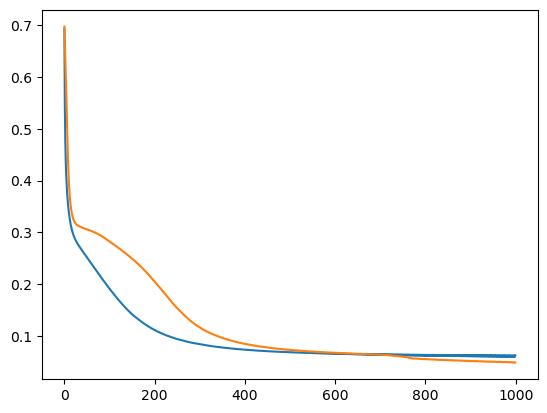

In [73]:
plt.plot(history_auto)
plt.plot(history)

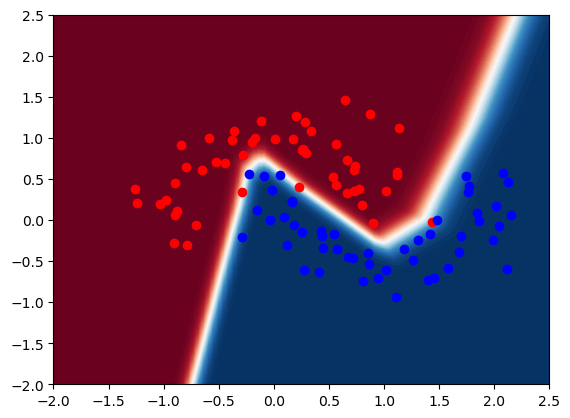

In [63]:
with torch.no_grad():
    visualize_classifier(
        lambda x: torch.sigmoid(torch.relu(torch.tensor(x, dtype=torch.float32) @ w1 + b1) @ w2 + b2),
        -2, 2.5, -2, 2.5, cmap="RdBu"
    )
plt.scatter(*X[y==0].T, color="red")
plt.scatter(*X[y==1].T, color="blue")

This does not look too great. There are 2 things we can improve:

* implement a bias for the neurons
* apply a sigmoid activation function to constrain the output to lie between 0 and 1
* switch to the binary cross entropy loss

<div class="alert alert-block alert-success">
    <h2>Exercise 3</h2>
    Add a bias term to the neurons<br>
    <b>Hint:</b> The Jacobi matrix of the output of a layer w.r.t. the biases is an identity matrix, so the VJP is the sum over the incoming gradient.<br>
    So if we have <code>z = a @ w + b</code>, the gradient <code>db = dz.sum(axis=0)</code>
</div>

<div class="alert alert-block alert-success">
    <h2>Exercise 4</h2>
    Apply a sigmoid activation function to the final output.<br>
    <b>Hint:</b> You can use <code>z = torch.sigmoid(a)</code>. The derivative of the sigmoid function is given by $f'(x) = f(x)(1-f(x))$
</div>

<div class="alert alert-block alert-success">
    <h2>Exercise 5</h2>
    Change the loss function to binary cross entropy.<br>
    <b>Reminder:</b> The formula is $L = \frac{1}{N}\sum_i y_i\log(\hat y_i) + (1 - y_i)\log(1 - \hat y_i)$ for NN outputs $\hat y_i$ and labels $y_i$
</div>